In [1]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
# import recipes.parquet into a pandas DataFrame
df: pd.DataFrame = pq.read_table('recipes.parquet').to_pandas()

In [2]:
COLUMNS_TO_KEEP = [
    'RecipeId',
    'Name',
    'AuthorName',
    'Description',
    'RecipeCategory',
    'Keywords',
    'RecipeIngredientParts',
    'Calories',
    'FatContent',
    'SaturatedFatContent',
    'CholesterolContent',
    'SodiumContent',
    'CarbohydrateContent',
    'FiberContent',
    'SugarContent',
    'ProteinContent',
]

df_columns= df[COLUMNS_TO_KEEP]
df_columns.head()

,RecipeId,Name,AuthorName,Description,RecipeCategory,Keywords,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
0,38.0,Low-Fat Berry Blue Frozen Dessert,Dancer,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"[Dessert, Low Protein, Low Cholesterol, Health...","[blueberries, granulated sugar, vanilla yogurt...",170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2
1,39.0,Biryani,elly9812,Make and share this Biryani recipe from Food.com.,Chicken Breast,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, ...","[saffron, milk, hot green chili peppers, onion...",1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4
2,40.0,Best Lemonade,Stephen Little,This is from one of my first Good House Keepi...,Beverages,"[Low Protein, Low Cholesterol, Healthy, Summer...","[sugar, lemons, rind of, lemon, zest of, fresh...",311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3
3,41.0,Carina's Tofu-Vegetable Kebabs,Cyclopz,This dish is best prepared a day in advance to...,Soy/Tofu,"[Beans, Vegetable, Low Cholesterol, Weeknight,...","[extra firm tofu, eggplant, zucchini, mushroom...",536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3
4,42.0,Cabbage Soup,Duckie067,Make and share this Cabbage Soup recipe from F...,Vegetable,"[Low Protein, Vegan, Low Cholesterol, Healthy,...","[plain tomato juice, cabbage, onion, carrots, ...",103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3


In [3]:
keywords = set()
for kw in df_columns['Keywords']:
    keywords.update(kw)
len(keywords)

315

In [4]:
ingredients = set()
for ing in df_columns['RecipeIngredientParts']:
    ingredients.update(ing)
len(ingredients)

7368

In [5]:
categories = set()
categories.update(df_columns['RecipeCategory'])
len(categories)

312

In [6]:
from typing import List

def nutrient_score(nutients: List[float], a: float = 0.1):
    return sum(map(lambda x: max(0, a * (x - 5) * (x - 20)), nutients))

NUTRIENT_COLUMNS = [
    'Calories',
    'FatContent',
    'SaturatedFatContent',
    'CholesterolContent',
    'SodiumContent',
    'CarbohydrateContent',
    'FiberContent',
#    'SugarContent', # There is no published DV for sugar
    'ProteinContent',
]

NUTRIENT_TARGET_DV = {
    'Calories': 2000,
    'FatContent': 78,
    'SaturatedFatContent': 20,
    'CholesterolContent': 300,
    'SodiumContent': 2300,
    'CarbohydrateContent': 275,
    'FiberContent': 28,
#    'SugarContent': 50, # 50g is the recommended daily limit for *added* sugar
    'ProteinContent': 50,
}

df_nutrients = df_columns.copy()
for column in NUTRIENT_COLUMNS:
    df_nutrients[column + 'DV'] = df_nutrients[column] / NUTRIENT_TARGET_DV[column]

df_nutrients['NutrientScore'] = df_nutrients[NUTRIENT_COLUMNS].apply(nutrient_score, axis=1)

In [7]:
# Drop values with nutrient score greater than MAX_SCORE
df_outliers = df_nutrients.copy()
print(len(df_outliers))
MAX_SCORE = 400_000
df_outliers = df_outliers[df_outliers['NutrientScore'] < MAX_SCORE]
print(len(df_outliers))

522517
479647


In [8]:
df_outliers.drop(columns=['Keywords', 'RecipeIngredientParts']).to_csv('recipes-dv.csv', index=False)

In [9]:
# Find the ratio of recipes with a calorie DV between 0.05 and 0.2 without creating a new df
calories = df_nutrients['CaloriesDV']
calories_filtered = calories[(calories > 0.05) & (calories < 0.2)]
calories_filtered_ratio = len(calories_filtered) / len(calories)
calories_filtered_ratio

0.5014152649578866

In [10]:
# The bottom calories_filtered_ratio% of the nutrient score column, are healthy
# Create a new boolean column called Healthy
df_healthy = df_nutrients.copy()
df_healthy['Healthy'] = df_healthy['NutrientScore'] < df_healthy['NutrientScore'].quantile(calories_filtered_ratio)

In [11]:
df_healthy.drop(columns=['Keywords', 'RecipeIngredientParts']).to_csv('recipes-healthy.csv', index=False)

In [12]:
def unique_elems(element_lists: List[List[str]]) -> List[str]:
    """Creates a list of all of the unique strings in the input lists
    This potentially be accomplished in a better way using sets, but sets 
    do not guarantee a specific order, which is necessary to keep the feature
    order consistent."""
    unique = []
    unique_set = set() # Uses a set to (theoretically) trade some extra memory usage to make `in` run in constant time
    for element_list in element_lists:
        for element in element_list:
            if element not in unique_set:
                unique_set.add(element)
                unique.append(element)
    return unique

In [13]:
# Get a list of all unique keywords and ingredients
# This is used to vectorize the keywords and ingredients columns
unique_keywords = unique_elems(df_healthy['Keywords'])
unique_ingredients = unique_elems(df_healthy['RecipeIngredientParts'])
# Quick check that the elements are actually unique
assert len(unique_keywords) == len(set(unique_keywords))
assert len(unique_ingredients) == len(set(unique_ingredients))

In [14]:
def vectorize(unique_elems: List[str], input_elems: List[str]) -> List[int]:
    """Creates a vector of 1s and 0s, where a 1 indicates that the element at that index
    is in the input_elems list"""
    vector = [0] * len(unique_elems)
    # for elem in input_elems:
    #     vector[unique_elems.index(elem)] = 1
    # This imlementation should be more efficient since len(unique_elems) is significantly larger than len(input_elems)
    # This is because input_elems is a subset of unique_elems
    for unique_elem in unique_elems:
        if unique_elem in input_elems:
            vector[unique_elems.index(unique_elem)] = 1
    return vector

In [40]:
df_vectorized = df_healthy.copy()
df_vectorized['KeywordsVector'] = df_vectorized['Keywords'].apply(lambda x: vectorize(unique_keywords, x))
# df_vectorized['IngredientVector'] = df_vectorized['RecipeIngredientParts'].apply(lambda x: vectorize(unique_ingredients, x))

KeyboardInterrupt: 

In [17]:
df_vectorized.to_parquet('recipes-vectorized.parquet') # Save the vectorized DataFrame to a parquet file
# This is done in favor of a csv to maintain the list structure of the vector columns
# Gzip the parquet file to save space
import gzip
with open('recipes-vectorized.parquet', 'rb') as f:
    with gzip.open('recipes-vectorized.parquet.gz', 'wb') as f_gz:
        f_gz.writelines(f)

In [1]:
import pandas as pd
# If the file is not already un-gzipped, unzip it
import gzip
import os
if not os.path.exists('recipes-vectorized.parquet'):
    with open('recipes-vectorized.parquet', 'wb') as f:
        with gzip.open('recipes-vectorized.parquet.gz', 'rb') as f_gz:
            f.write(f_gz.read())
df_vectorized = pd.read_parquet('recipes-vectorized.parquet') # Read the vectorized DataFrame from the parquet file

In [2]:
df_vectorized.head()

,RecipeId,Name,AuthorName,Description,RecipeCategory,Keywords,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,...,FatContentDV,SaturatedFatContentDV,CholesterolContentDV,SodiumContentDV,CarbohydrateContentDV,FiberContentDV,ProteinContentDV,NutrientScore,Healthy,KeywordsVector
0,38.0,Low-Fat Berry Blue Frozen Dessert,Dancer,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"[Dessert, Low Protein, Low Cholesterol, Health...","[blueberries, granulated sugar, vanilla yogurt...",170.9,2.5,1.3,...,0.032051,0.065,0.026667,0.012957,0.134909,0.128571,0.064,2599.240,True,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
1,39.0,Biryani,elly9812,Make and share this Biryani recipe from Food.com.,Chicken Breast,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, ...","[saffron, milk, hot green chili peppers, onion...",1110.7,58.8,16.6,...,0.753846,0.830,1.242667,0.160174,0.306909,0.321429,1.268,147209.075,False,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, ..."
2,40.0,Best Lemonade,Stephen Little,This is from one of my first Good House Keepi...,Beverages,"[Low Protein, Low Cholesterol, Healthy, Summer...","[sugar, lemons, rind of, lemon, zest of, fresh...",311.1,0.2,0.0,...,0.002564,0.000,0.000000,0.000783,0.296364,0.014286,0.006,9434.649,True,"[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,41.0,Carina's Tofu-Vegetable Kebabs,Cyclopz,This dish is best prepared a day in advance to...,Soy/Tofu,"[Beans, Vegetable, Low Cholesterol, Weeknight,...","[extra firm tofu, eggplant, zucchini, mushroom...",536.1,24.0,3.8,...,0.307692,0.190,0.000000,0.677652,0.233455,0.617857,0.586,266750.774,False,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,42.0,Cabbage Soup,Duckie067,Make and share this Cabbage Soup recipe from F...,Vegetable,"[Low Protein, Vegan, Low Cholesterol, Healthy,...","[plain tomato juice, cabbage, onion, carrots, ...",103.6,0.4,0.1,...,0.005128,0.005,0.000000,0.417087,0.091273,0.171429,0.086,90502.116,False,"[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [4]:
df_sample = df_vectorized.sample(frac=0.1) # Sample 10% of the data

In [5]:
X = df_sample['KeywordsVector'].to_list()
y = df_sample['Healthy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [8]:
classifier.score(X_test, y_test)

0.6327796065222384

In [6]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9, 11]}, verbose=3, n_jobs=-1, cv=3)
grid_search.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END ....................n_neighbors=11;, score=0.649 total time=45.4min
[CV 1/3] END ....................n_neighbors=11;, score=0.644 total time=46.1min
[CV 3/3] END ....................n_neighbors=11;, score=0.642 total time=45.5min


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [11]}, verbose=3)

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
grid_search_svm = GridSearchCV(SVC(), {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}, verbose=3, n_jobs=-1, cv=3)
grid_search_svm.fit(X, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
grid_search_xgb = GridSearchCV(XGBClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}, verbose=3, n_jobs=-1, cv=3)
grid_search_xgb.fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END .....max_depth=3, n_estimators=100;, score=0.677 total time=  21.8s


/home/greg/recipe-classifier/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/3] END .....max_depth=3, n_estimators=100;, score=0.674 total time=  20.7s
[CV 3/3] END .....max_depth=3, n_estimators=100;, score=0.677 total time=  19.0s
[CV 1/3] END .....max_depth=3, n_estimators=200;, score=0.679 total time=  36.1s
[CV 2/3] END .....max_depth=3, n_estimators=200;, score=0.675 total time=  31.3s
[CV 3/3] END .....max_depth=3, n_estimators=200;, score=0.679 total time=  33.4s
[CV 1/3] END .....max_depth=3, n_estimators=300;, score=0.679 total time=  45.7s
[CV 2/3] END .....max_depth=3, n_estimators=300;, score=0.676 total time=  45.0s
[CV 1/3] END .....max_depth=5, n_estimators=100;, score=0.680 total time=  22.0s
[CV 3/3] END .....max_depth=3, n_estimators=300;, score=0.680 total time=  46.3s
[CV 2/3] END .....max_depth=5, n_estimators=100;, score=0.676 total time=  20.9s
[CV 3/3] END .....max_depth=5, n_estimators=100;, score=0.680 total time=  20.7s
[CV 1/3] END .....max_depth=5, n_estimators=200;, score=0.680 total time=  34.3s
[CV 2/3] END .....max_depth=

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             verbose=3)

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
grid_search_mlp = GridSearchCV(MLPClassifier(), {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)], 'alpha': [0.0001, 0.001, 0.01]}, verbose=3, n_jobs=-1, cv=3)
# Sample 10%
df_sample = df_vectorized.sample(frac=0.05)
X = df_sample['KeywordsVector'].to_list()
y = df_sample['Healthy']
grid_search_mlp.fit(X, y)
import pickle
with open('classifier_mlp.pkl', 'wb') as f:
    pickle.dump(grid_search_mlp, f)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/greg/recipe-classifier/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/greg/recipe-classifier/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/greg/recipe-classifier/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/greg/recipe-classifier/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/greg/recipe-classifier/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  wa

KeyboardInterrupt: 

In [ ]:
import pickle
with open('classifier.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

with open('classifier_svm.pkl', 'wb') as f:
    pickle.dump(grid_search_svm, f)

with open('classifier_xgb.pkl', 'wb') as f:
    pickle.dump(grid_search_xgb, f)

with open('classifier_mlp.pkl', 'wb') as f:
    pickle.dump(grid_search_mlp, f)

To help reduce dimensionality, we will use 2 approaches. First we will do manual corpus reduction.

This is done by first removing words from the corpus that do not have any bearing on health.

Then, similar keywords will be grouped together. Ex:

Countries, for the most part, get grouped together into their respective continents. (Some exceptions are made for countries whose cuisine is very different from the rest of the continent)

Fruits, vegetables, fish, chicken, beef etc. are grouped together into their respective food groups.

In [18]:
# Corpus filtering
# Write keywords to a file
with open('keywords.txt', 'w') as f:
    for keyword in unique_keywords:
        f.write(keyword + '\n') if keyword else None

This keywords file was then manually reduced following the steps above into a new file called combinations.txt

In [37]:
# Read combinations.txt
# Split by double newline
# Each row between double newline is a combination
# The first row is the category name but can also be a keyword
combinations = []
with open('combinations.txt', 'r') as f:
    combinations = f.read().split('\n\n')

# Create a dictionary of categories to keywords
category_keywords = {}
for combination in combinations:
    lines = combination.split('\n')
    category = lines[0]
    keywords = lines[:] # Copy the list (Categories can also be keywords)
    category_keywords[category] = keywords

In [38]:
df_categorized_keywords = df_healthy.copy()

def get_keyword_categories(keywords: List[str], category_keywords: dict) -> List[str]:
    """
    Given a list of keywords and a dictionary of categories to keywords, return the categories that the keywords belong to
    """
    categories = []
    for keyword in keywords:
        for category, category_keywords_list in category_keywords.items():
            if keyword in category_keywords_list:
                if category not in categories:
                    categories.append(category)
    return categories

df_categorized_keywords['KeywordCategoriesVector'] = df_categorized_keywords['Keywords'].apply(lambda x: vectorize(list(category_keywords.keys()), get_keyword_categories(x, category_keywords)))

The second approach is to use Principal Component Analysis (PCA) to reduce the dimensionality of the data.

In [39]:
# PCA on original data
from sklearn.decomposition import PCA
pca_95 = PCA(0.95)
X_95 = df_categorized_keywords['KeywordsVector'].to_list()
X_pca_95 = pca_95.fit_transform(X_95)

pca_90 = PCA(0.90)
X_90 = df_categorized_keywords['KeywordsVector'].to_list()
X_pca_90 = pca_90.fit_transform(X_90)

# Print components and explained variance
print(pca_95.components_)
print(pca_95.explained_variance_ratio_)
print(pca_90.components_)
print(pca_90.explained_variance_ratio_)

KeyError: 'KeywordsVector'

Text(0.5, 1.0, 'Keyword Frequency Distribution')

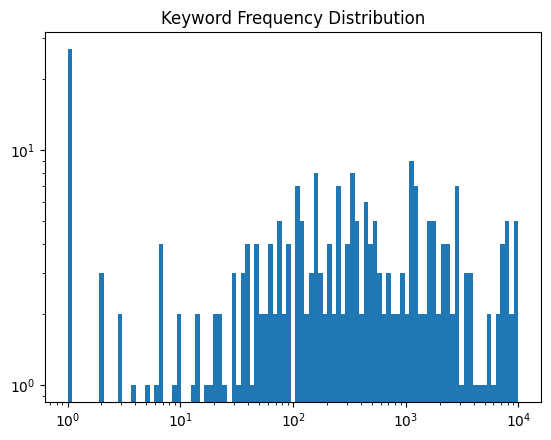

In [21]:
# Get a count of all unique keywords
keyword_count = {}
for keyword in unique_keywords:
    keyword_count[keyword] = 0
for keywords in df_vectorized['Keywords']:
    for keyword in keywords:
        keyword_count[keyword] += 1
    
# Plot freq distribution of keyword counts
import matplotlib.pyplot as plt
import numpy as np
plt.hist(keyword_count.values(), bins=np.logspace(0, 4, 100))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.title('Keyword Frequency Distribution')